# Reinforcement Learning for Dynamic Product Sorting
### Q-Learning Implementation

In [5]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import itertools
from itertools import count

### Enviroment Functions

In [6]:
def initialState():
    state = list(np.random.randint(0,3) for x in range(3))
    state.extend([0, 0]) # add empty pallet
    return tuple(state)

def newProduct():
    return np.random.randint(1,3)

def getPossibleActions(state, numberOfActions):
    possibleActions = [0 for i in range(numberOfActions)]
    if state[0] != 0: # if belt is not empty
        for i in range(2): #range(buffer_size)
            if state[1+i] == 0: # belt_size+i # if buffer spot empty 
                possibleActions[i] = 1 # belt to pallet
        possibleActions[2] = 1 # [buffer_size] # move belt product to pallet 
    for i in range(2): #range(buffer_size)
        if state[1+i] != 0: # belt_size+i # if product in buffer spot
            possibleActions[2 + 1 + i] = 1 # [buffer_size+1+i] # move buffer product to pallet
    possibleActions[-1] = 1 #wait
    return possibleActions


def getNextState(state, action):
    done = False
    state = list(state)
    pallet = [state[3], state[4]]
    if action in range(2): # range(buffer_size) # move belt to buffer
        prod = state[0] # belt product
        state[0] = newProduct() # new belt product
        state[1+action] = prod # move product to buffer spot
    elif action in range(2,3): # range(buffer_size to buffer_size + belt_size) # move belt to pallet
        prod = state[0] # belt product
        for i in range(-2,0): #range(pallet capacity)
            if state[i] == 0:
                state[0] = newProduct() # new belt product
                state[i] = prod # move product to pallet
                break
            else:
                if state[-1] != 0:
                    raise('Tried to place belt item in pallet, but pallet is full')
    elif action in range(3,5): # range(buffer_size + belt_size to 2*buffer_size + belt_size) # move buffer to pallet
        prod = state[action-2] # range(action - buffer_cap) # buffer product
        for i in range(-2,0): #range(pallet capacity)
            if state[i] == 0:
                state[action-2] = 0 # remove buffer product
                state[i] = prod # place buffer product on belt
                break
            else:
                if state[-1] != 0:
                    raise('Tried to place buffer item in pallet, but pallet is full')
    else: #wait
        if state[0] == 0: # if belt is empty
            state[0] = newProduct()
    reward = -0.1 # minus 0.1 for every action taken
    if state[-1] != 0: # if pallet full
        reward += state[-2] - state[-1] # reward added to initial
        # empty full pallet
        state[-1] = 0
        state[-2] = 0
        done = True
    return tuple(state), reward, done

### Implementation


In [7]:
num_episodes = 5000
states = list(itertools.product([0, 1, 2], repeat=5)) # size 5 (belt, buffer0 buffer1, pallet0, pallet1)
num_states = len(states)
actions = [i for i in range(2+1+2+1)] # belt to buffer, belt to pallet, buffer to pallet, wait
num_actions = len(actions)
Q = {state: {action : 0 for action in np.argwhere(np.array(getPossibleActions(state, num_actions))!=0).flatten()} for state in states}
Q_plot = {state: {action :  [0 for _ in range(num_episodes)] for action in np.argwhere(np.array(getPossibleActions(state, num_actions))!=0).flatten()} for state in states}
pi = {state: {action : 0 for action in np.argwhere(np.array(getPossibleActions(state, num_actions))!=0).flatten()} for state in states}
pi = {state: {action : 1/len(pi[state]) for action in pi[state].keys()} for state in states} # initialize random policy
epsilon = 0.8
step_size = 0.2
alpha = 0.05
gamma = 0.9


for i_episode in range(num_episodes):
    print(f'Episode: {i_episode+1}/{num_episodes}', end='\r')

    # Initial State
    state = initialState()

    for t in count():
        # Choose an action
        action = np.random.choice(list(pi[state].keys()), p = list(pi[state].values()))

        next_state, reward, done = getNextState(state, action)

        next_greedy_action = max(Q[next_state], key=Q[next_state].get)
        Q[state][action] = Q[state][action] + alpha*( reward + gamma*Q[next_state][next_greedy_action] - Q[state][action]  )
        greedy_action = max(Q[state], key=Q[state].get)
        pi[state] = {action: epsilon/len(pi[state]) for action in pi[state].keys()}
        pi[state][greedy_action] += 1-epsilon
        state = next_state

        if done:
            break
        
    for s in states:
        for a in Q_plot[s].keys():
            Q_plot[s][a][i_episode] = Q[s][a]
            
print('Complete')

Complete 5000/5000


### Plot Q Values


<ipython-input-8-8220e102b002>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


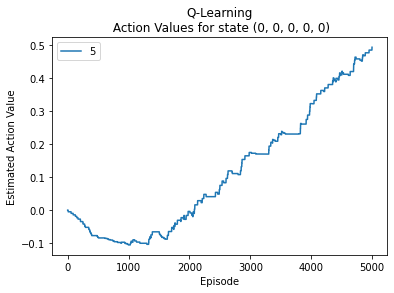

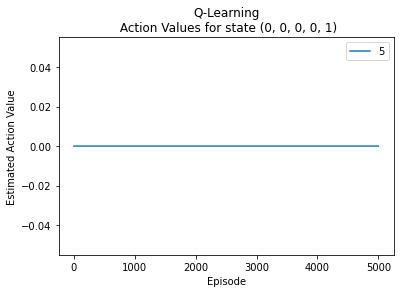

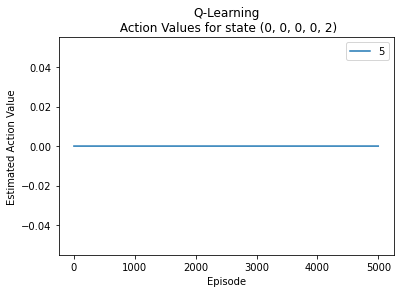

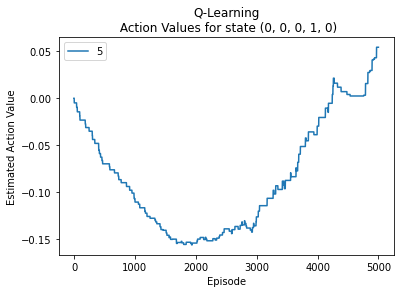

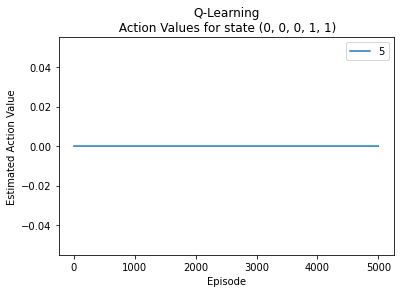

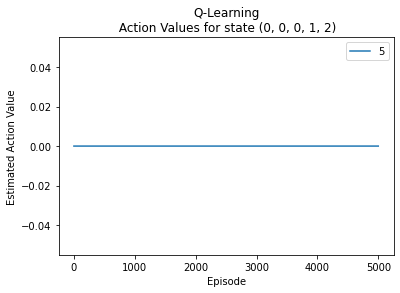

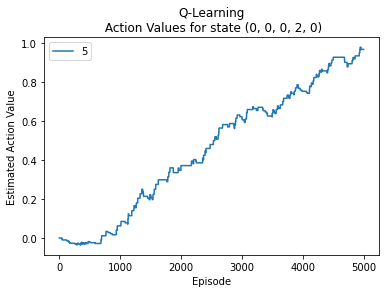

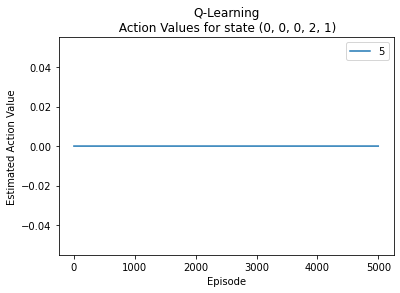

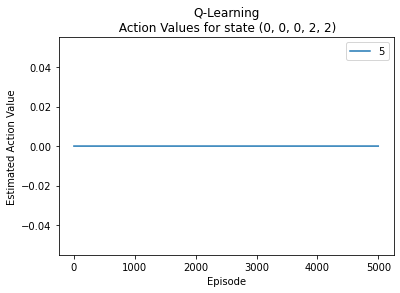

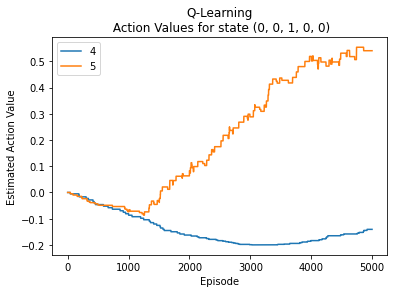

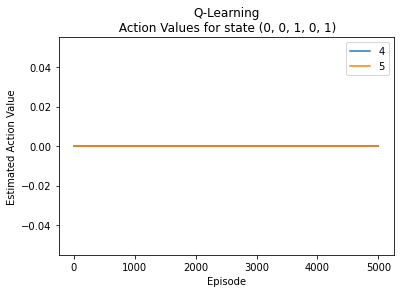

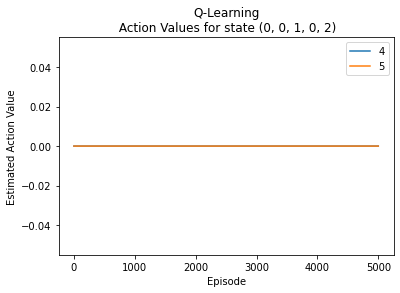

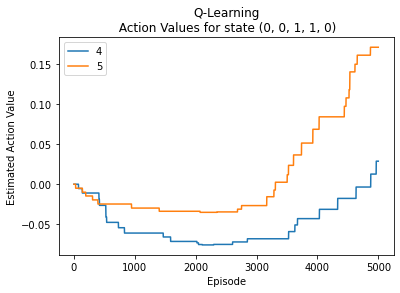

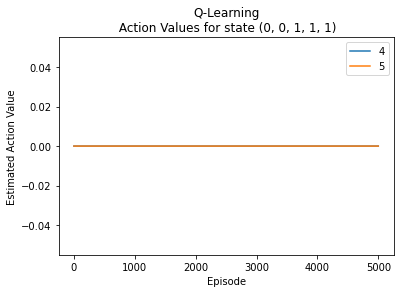

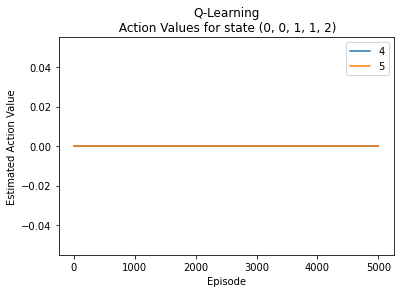

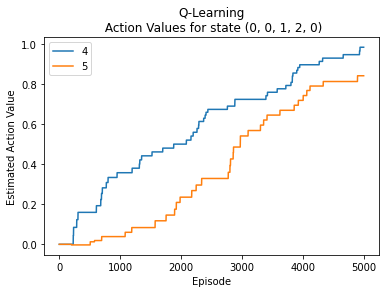

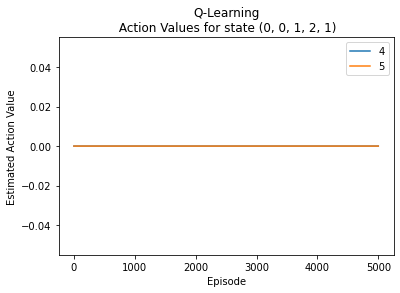

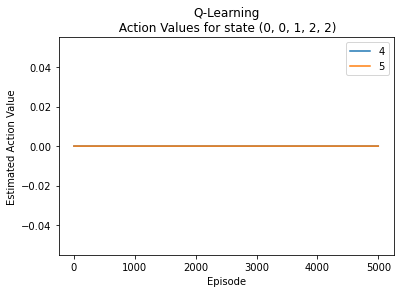

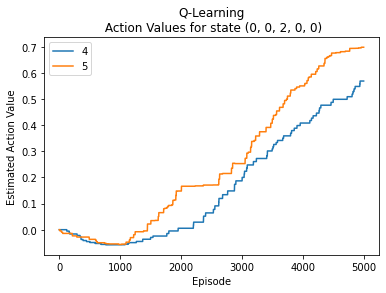

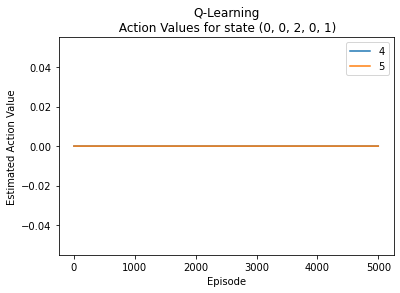

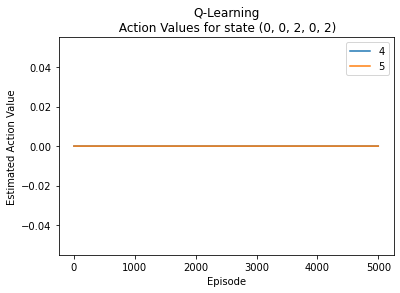

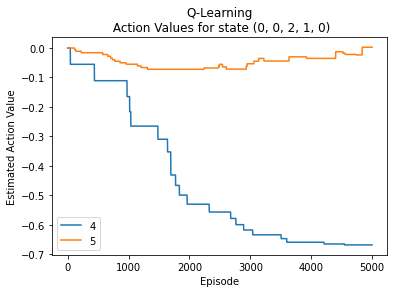

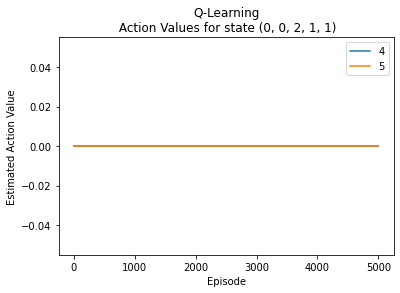

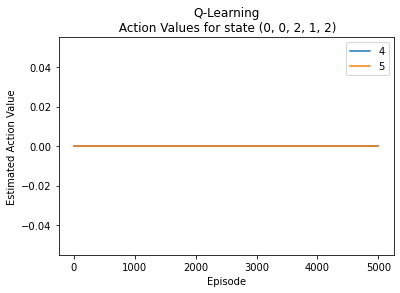

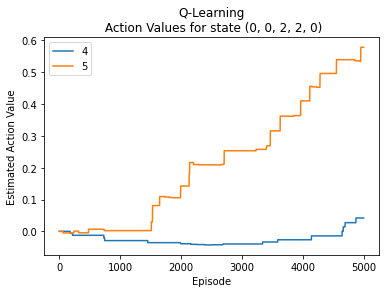

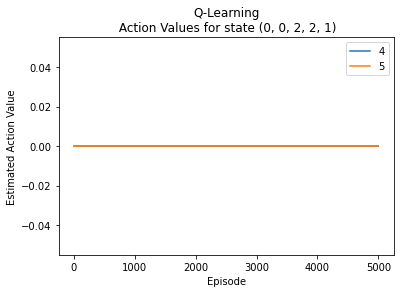

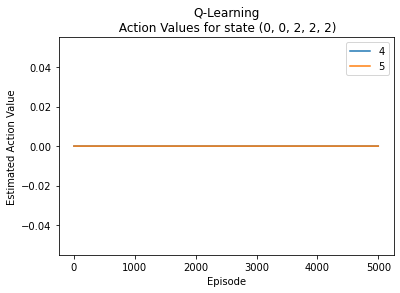

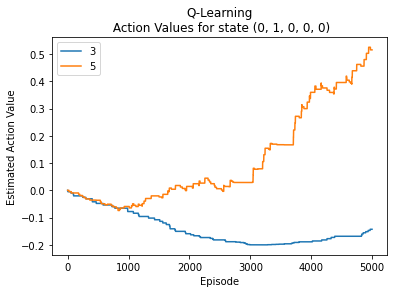

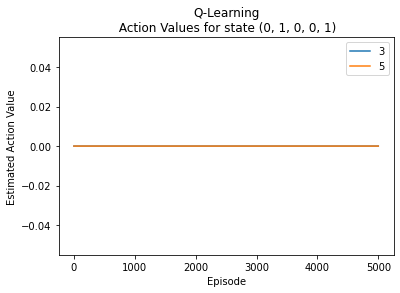

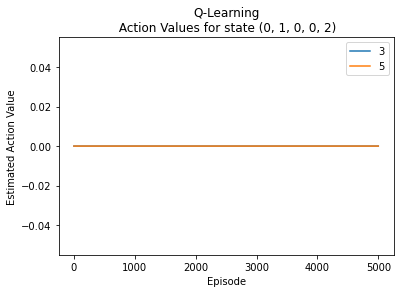

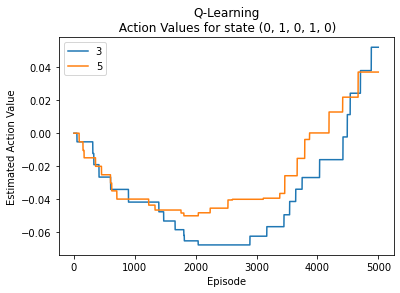

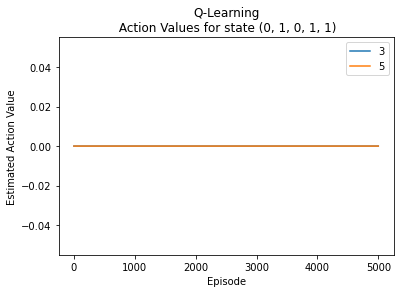

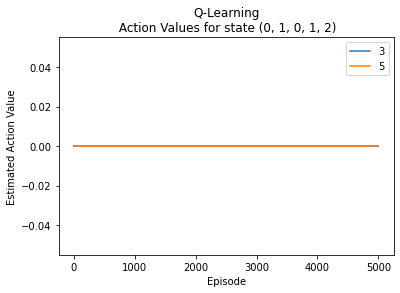

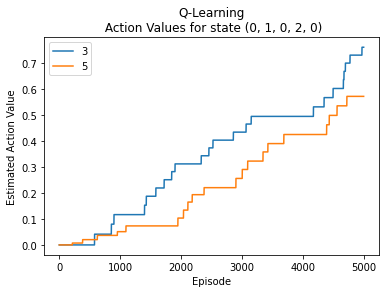

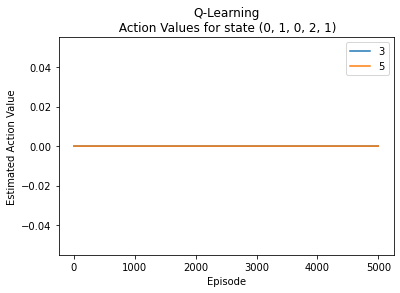

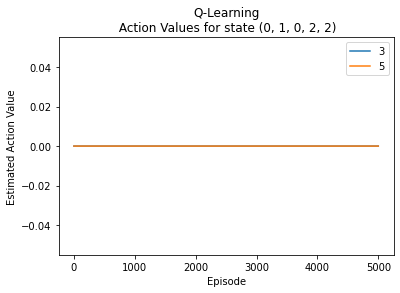

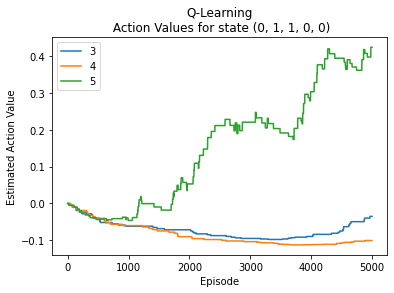

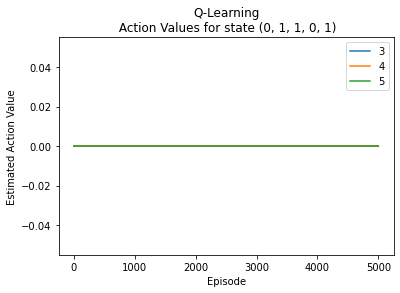

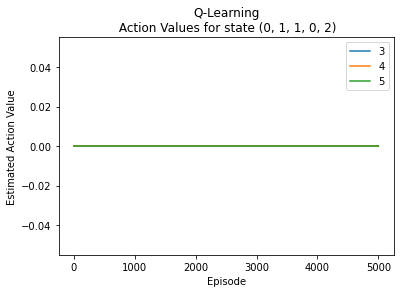

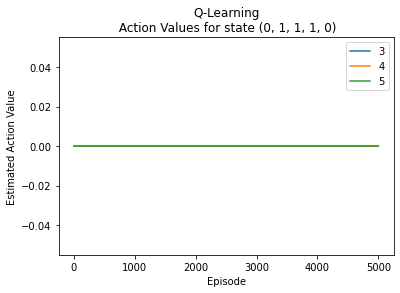

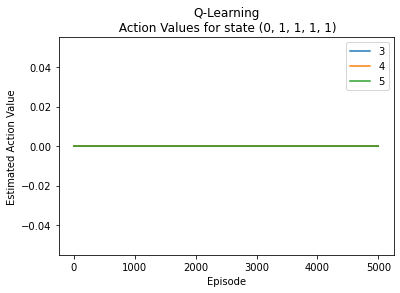

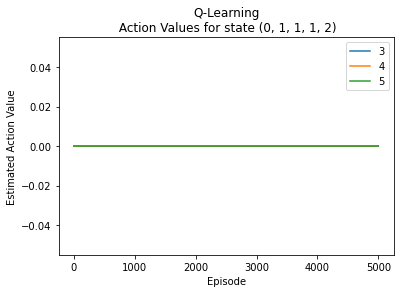

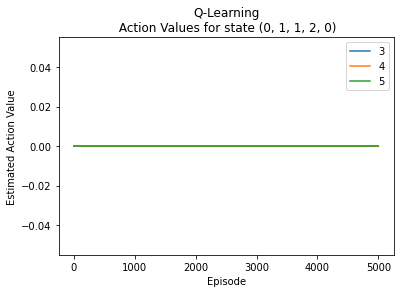

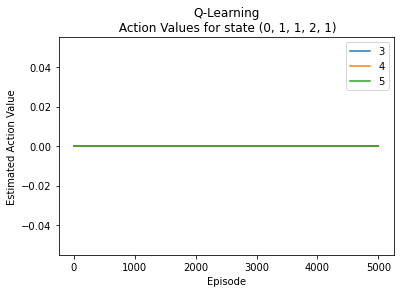

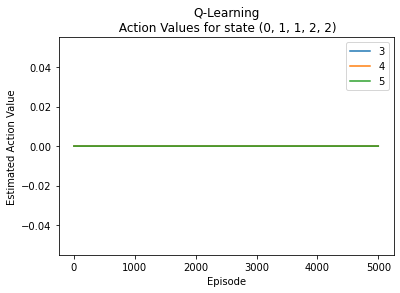

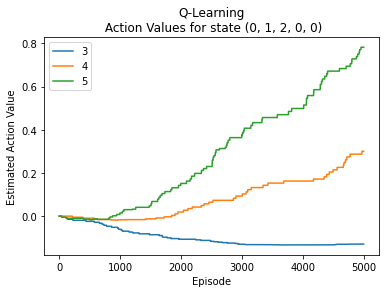

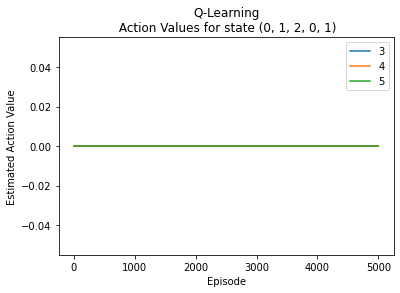

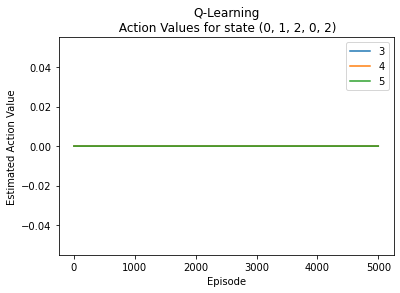

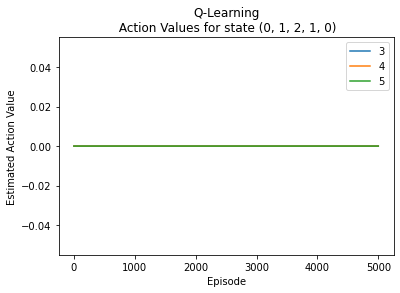

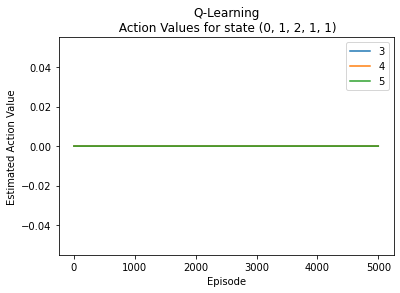

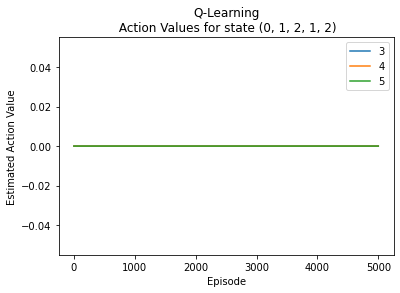

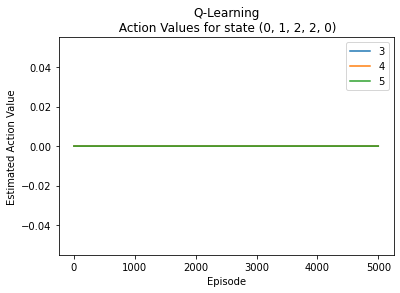

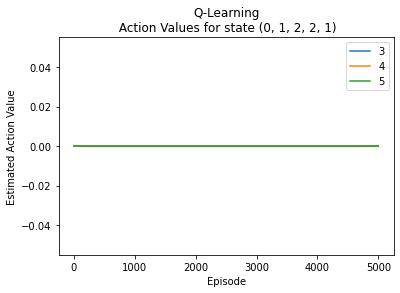

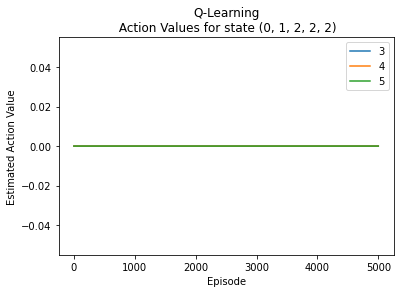

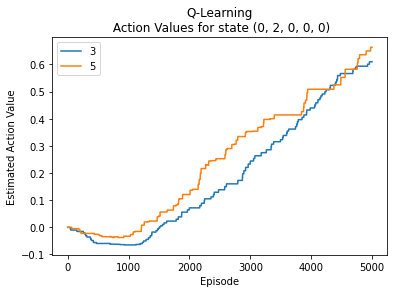

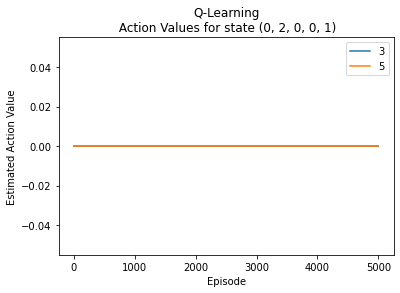

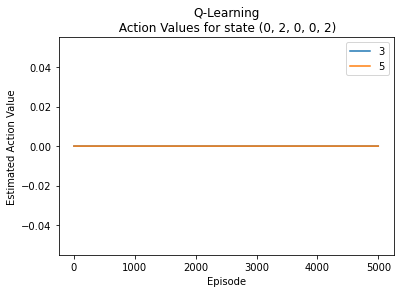

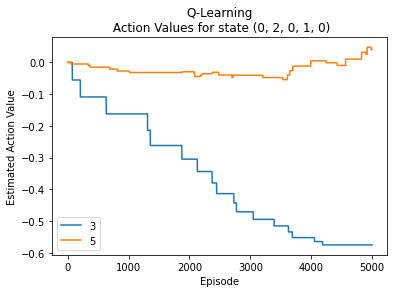

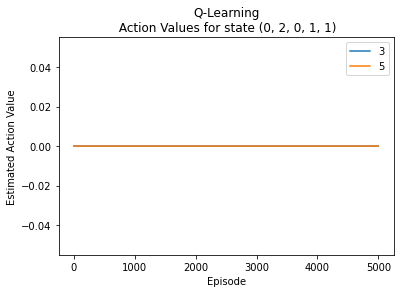

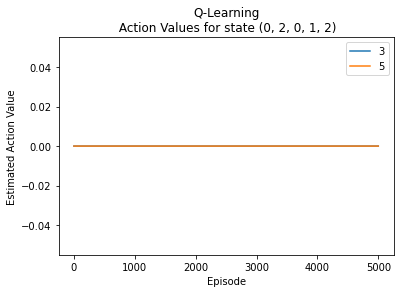

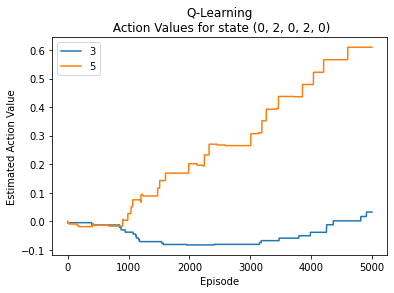

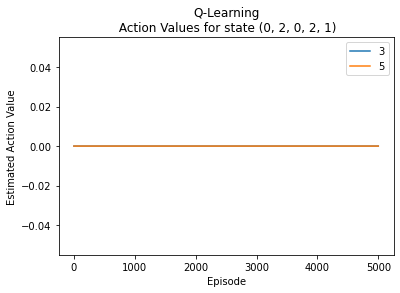

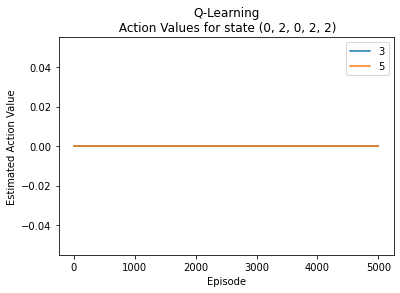

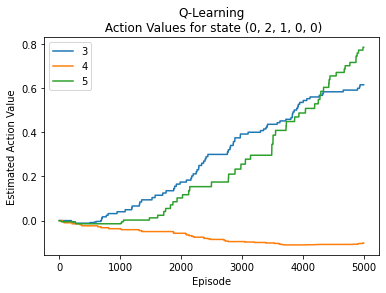

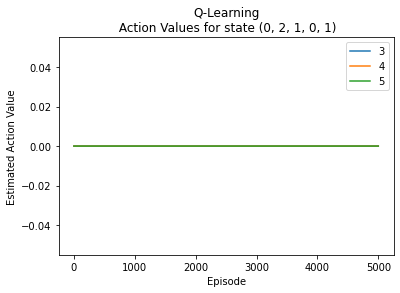

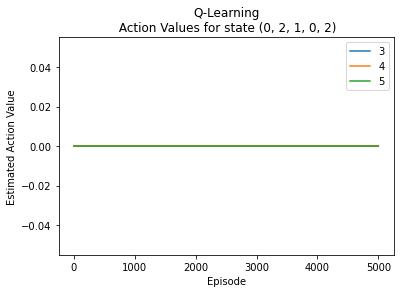

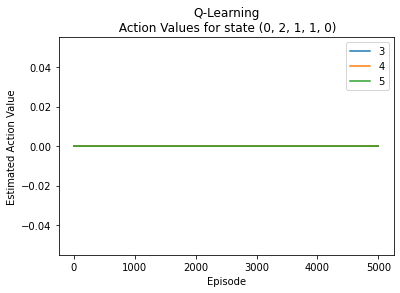

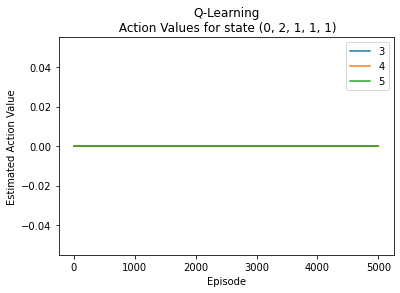

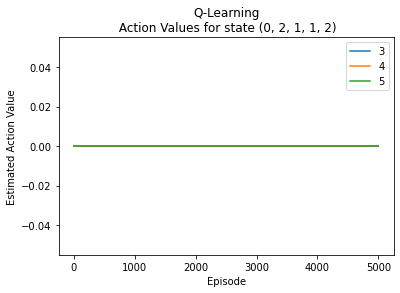

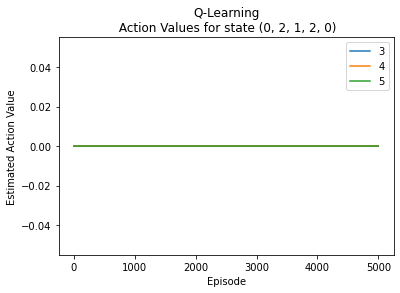

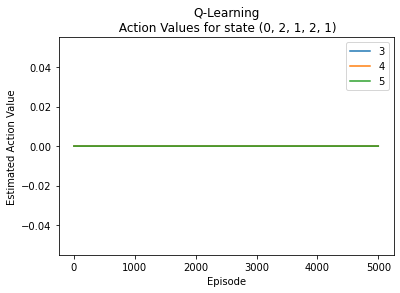

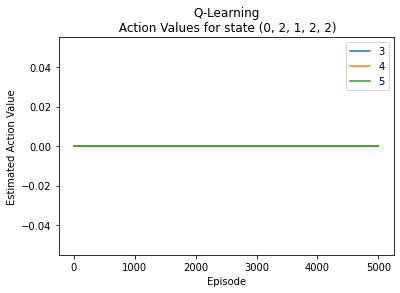

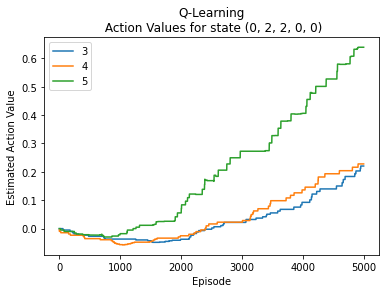

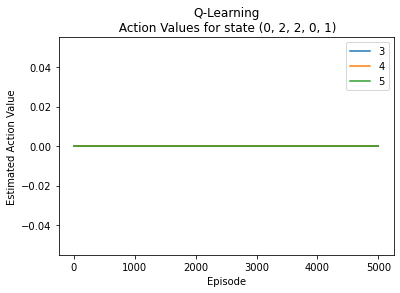

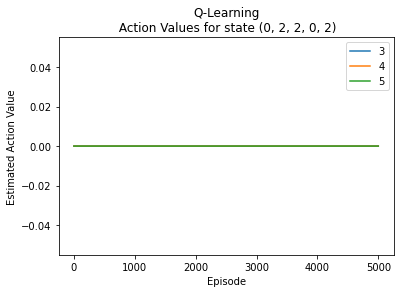

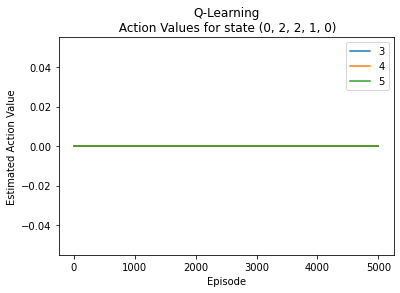

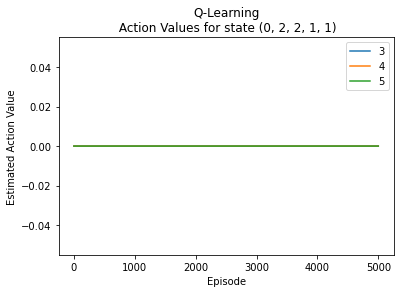

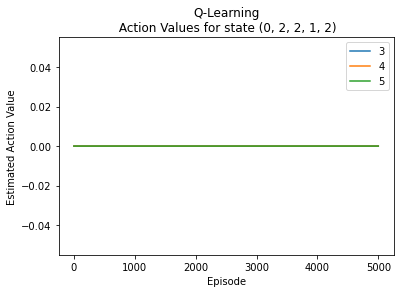

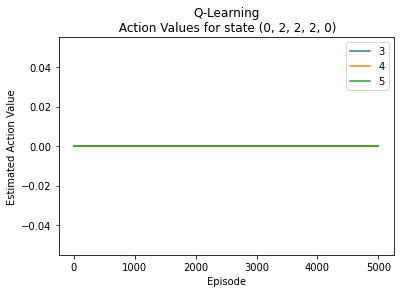

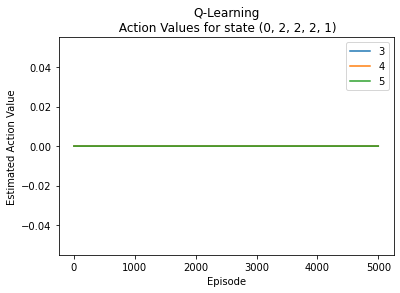

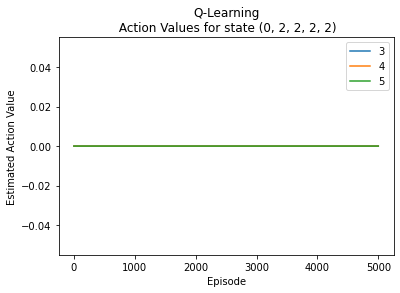

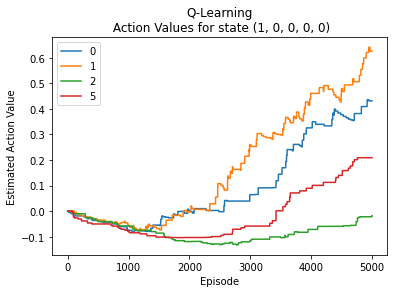

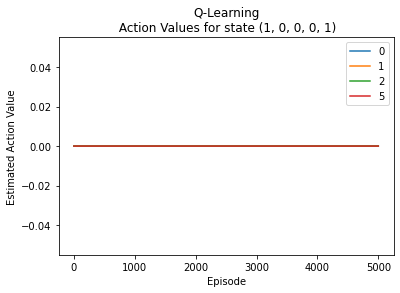

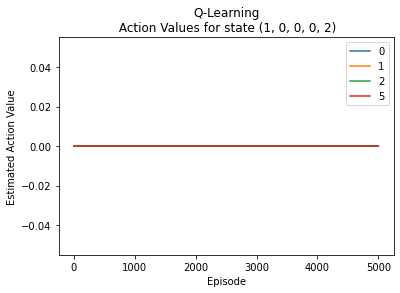

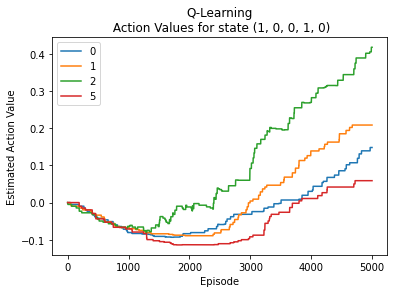

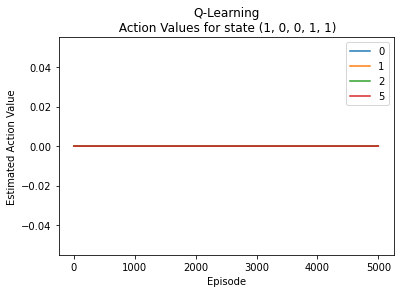

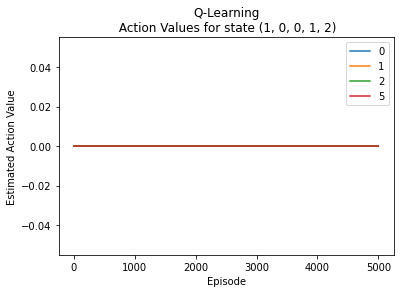

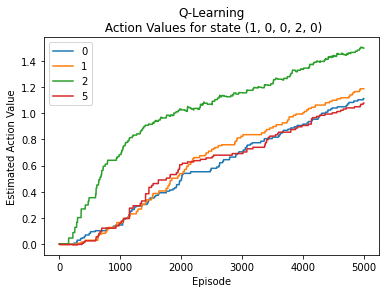

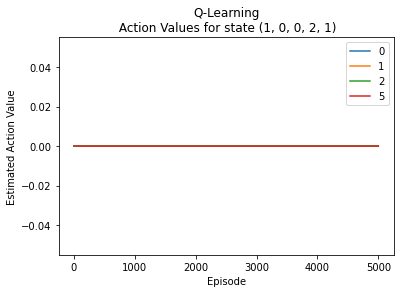

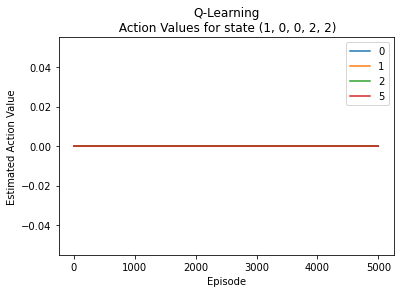

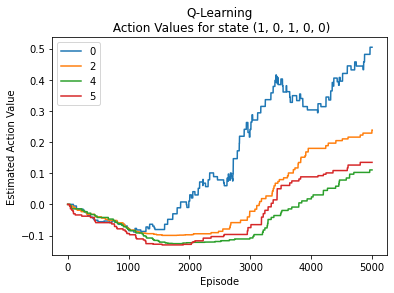

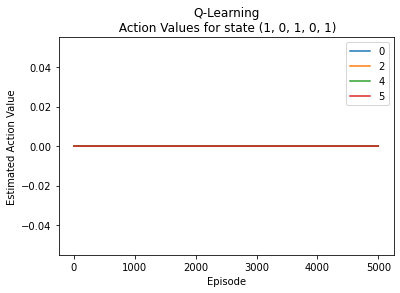

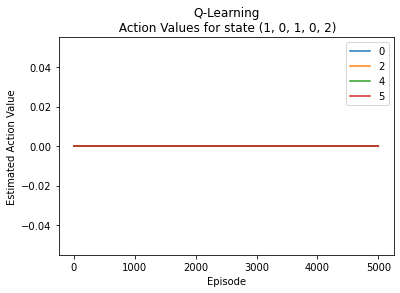

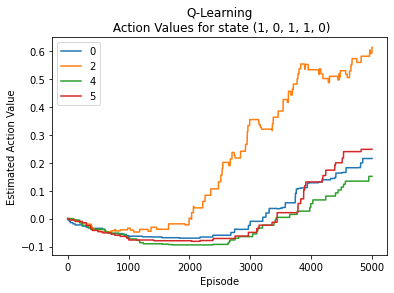

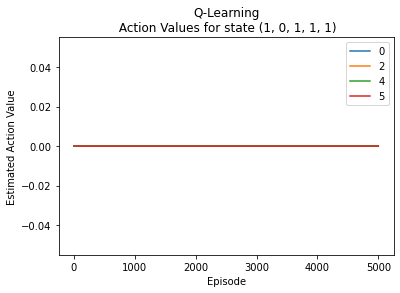

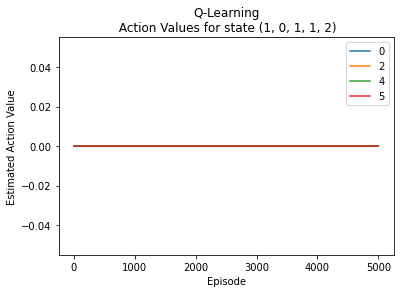

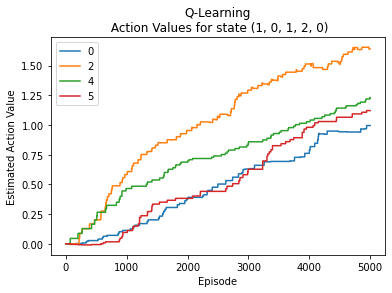

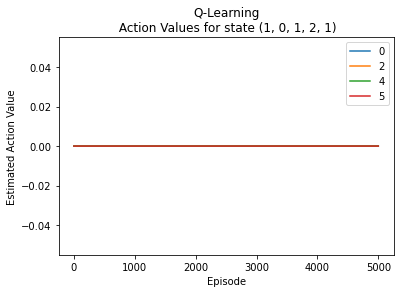

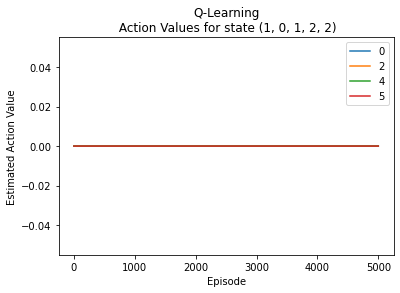

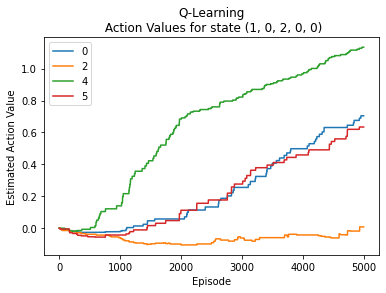

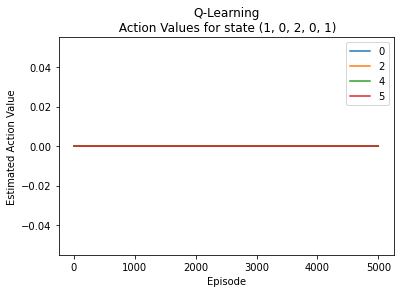

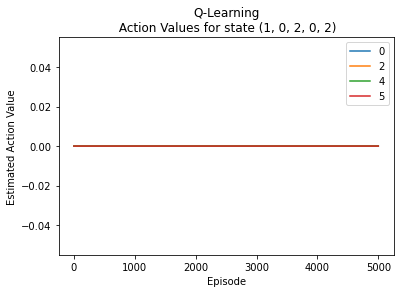

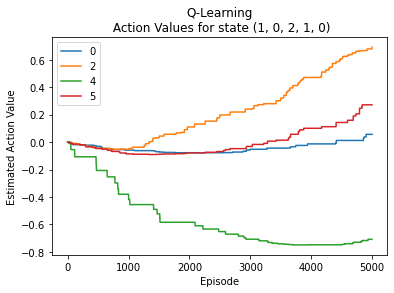

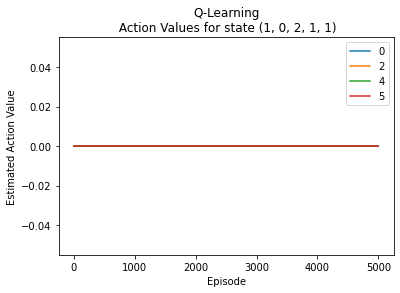

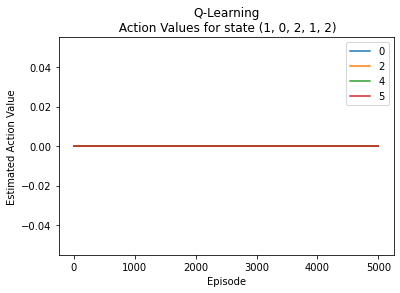

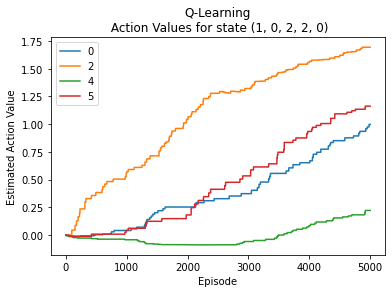

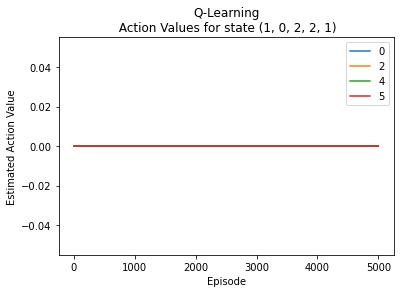

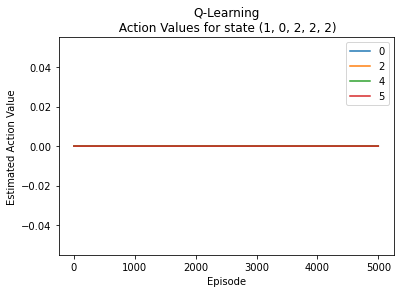

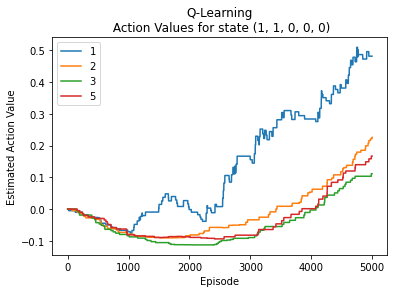

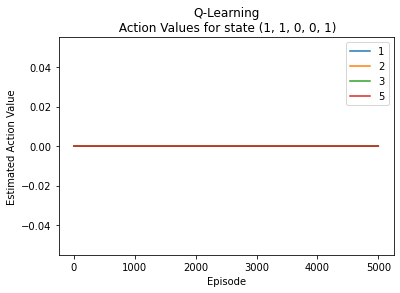

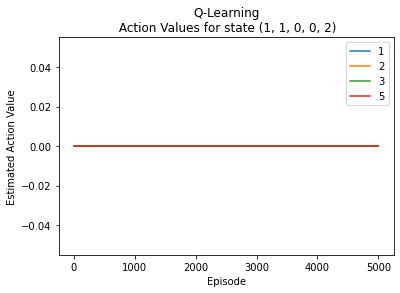

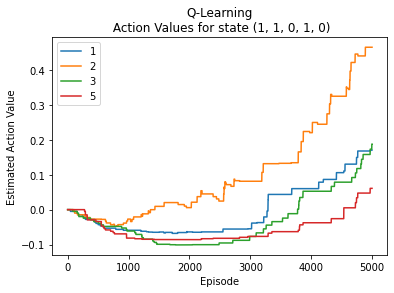

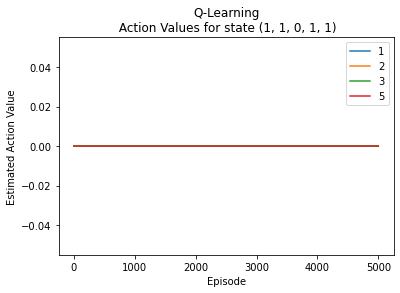

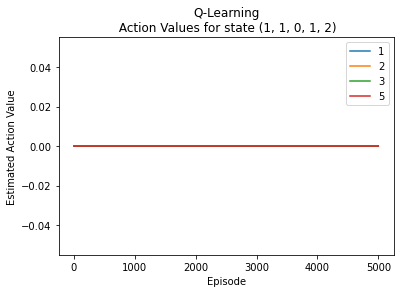

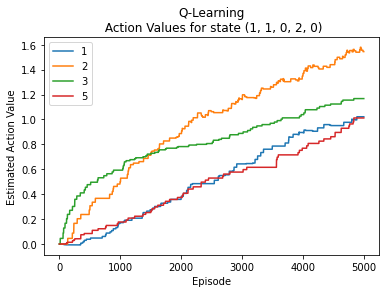

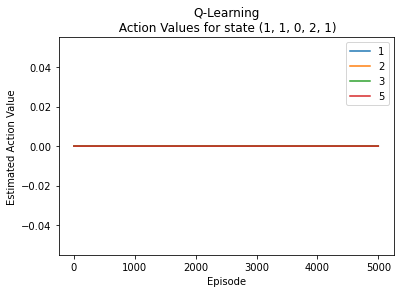

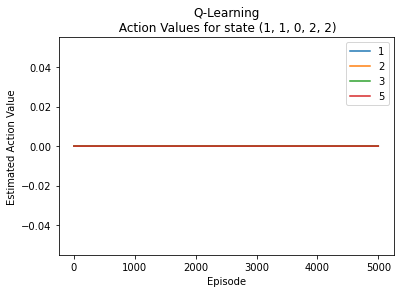

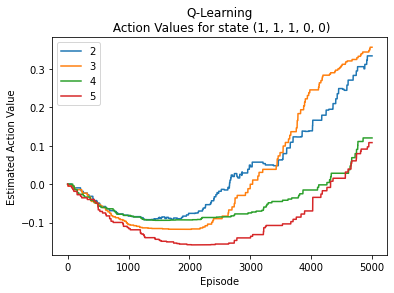

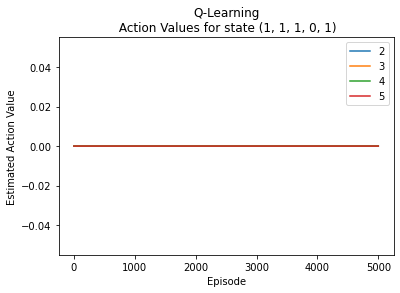

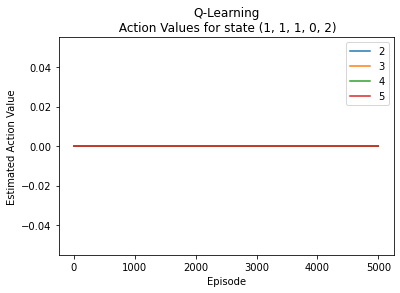

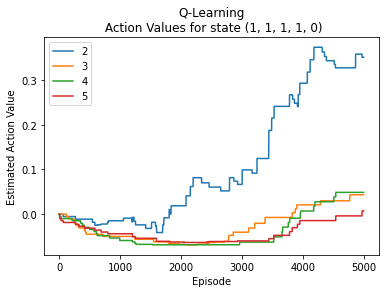

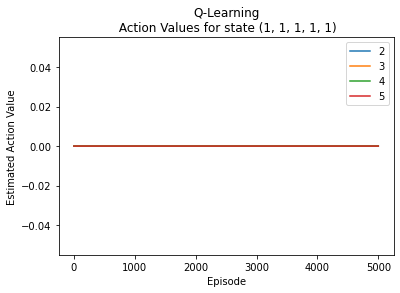

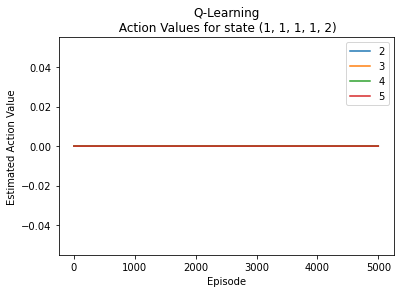

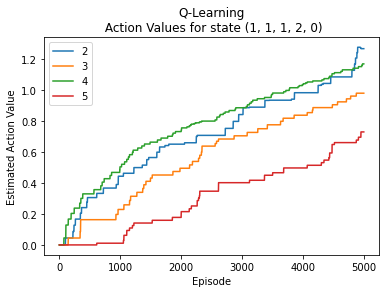

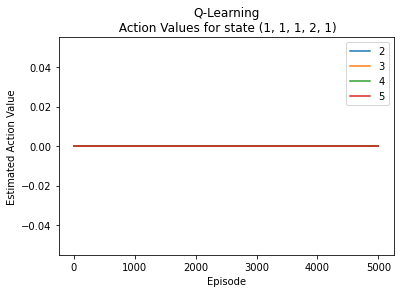

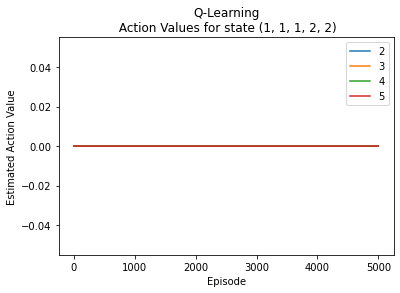

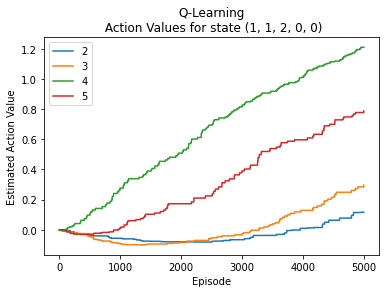

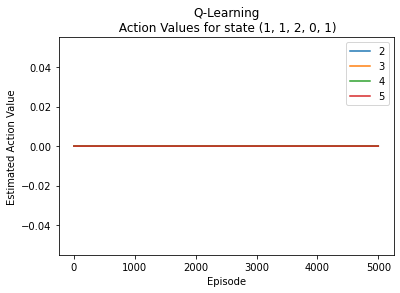

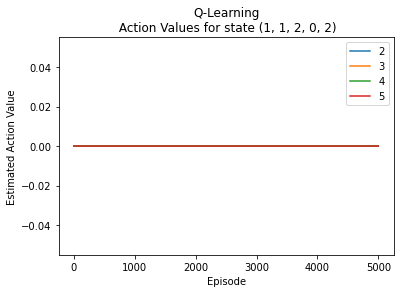

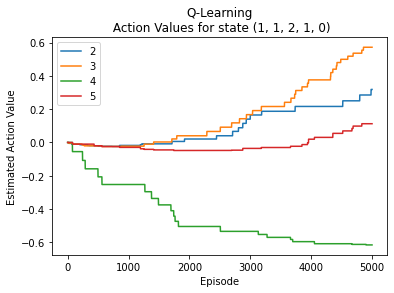

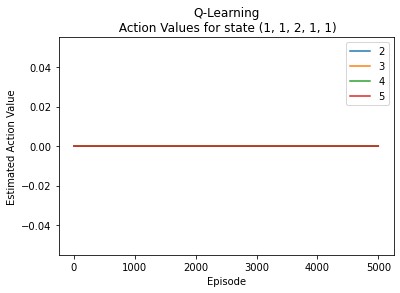

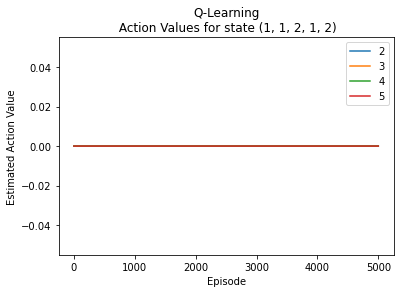

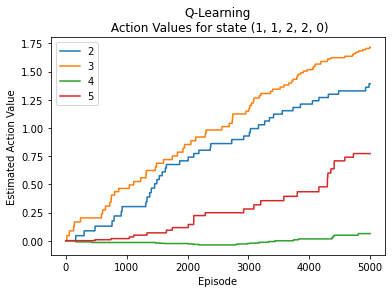

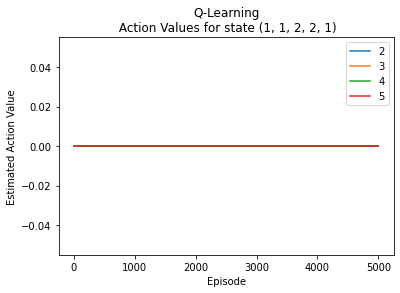

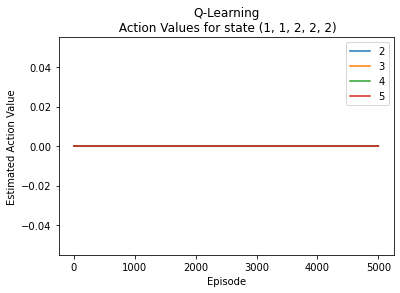

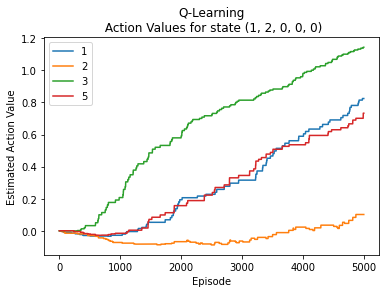

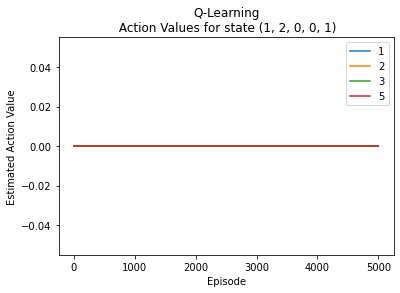

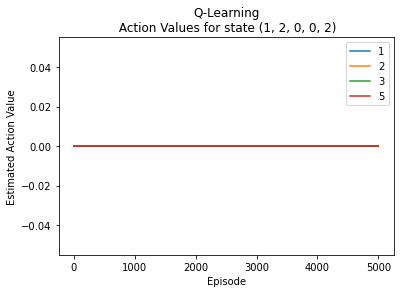

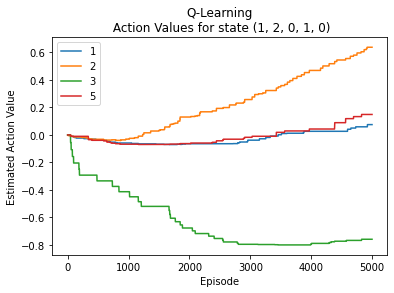

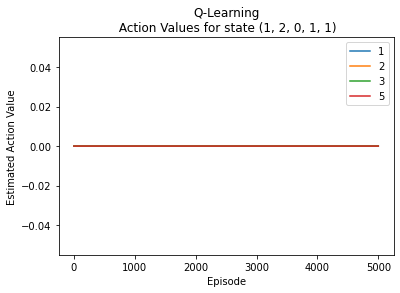

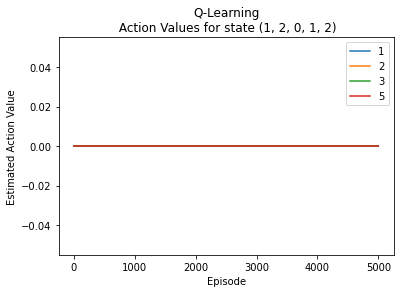

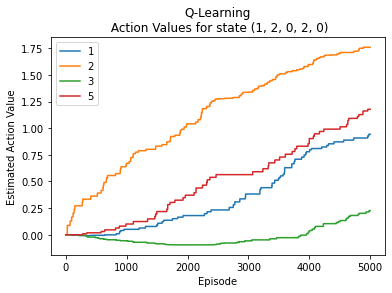

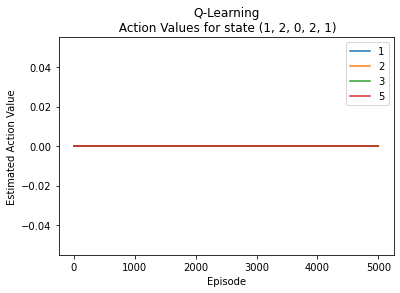

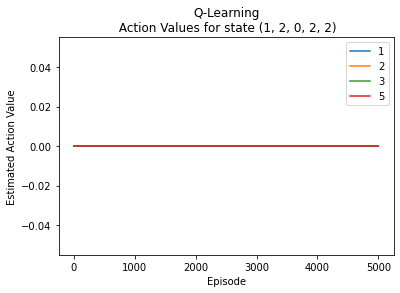

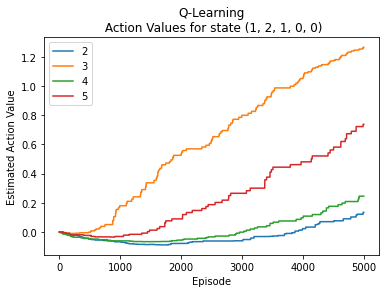

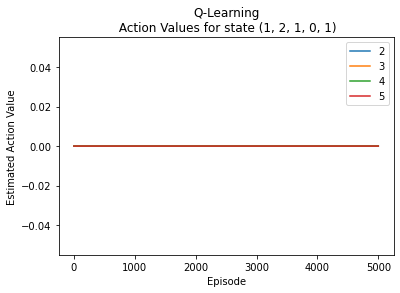

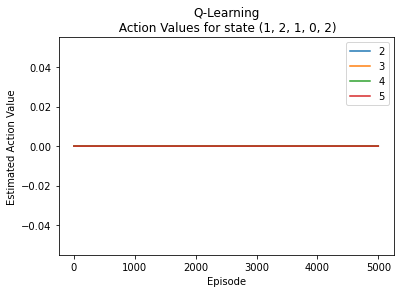

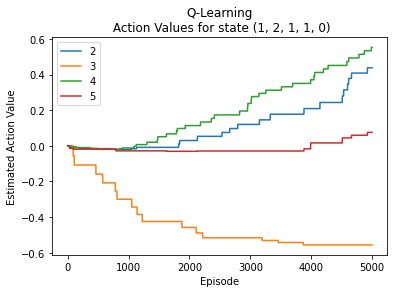

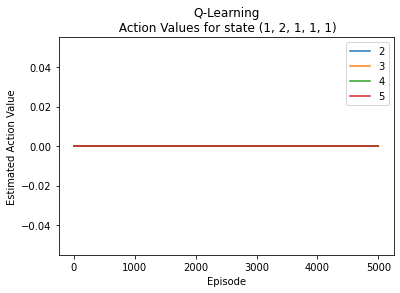

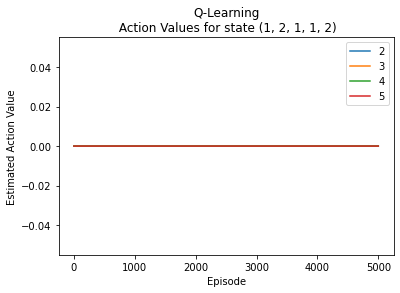

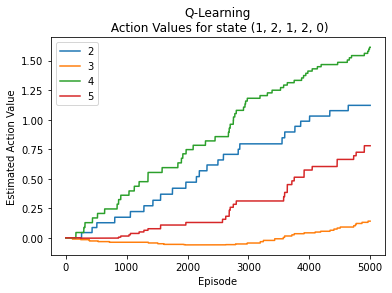

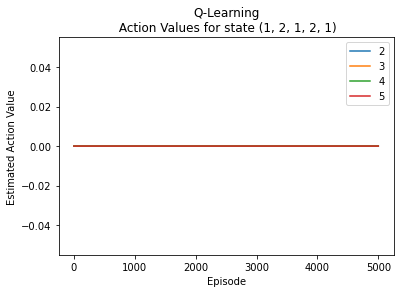

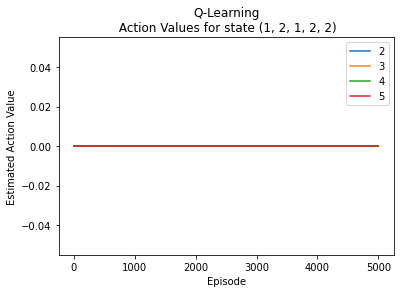

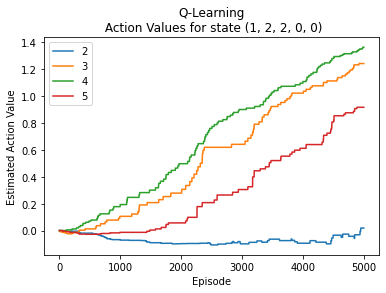

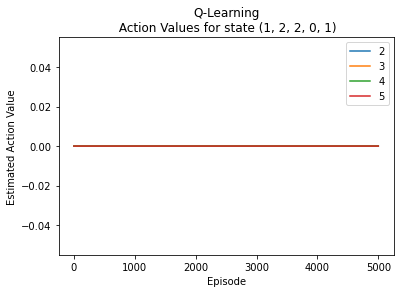

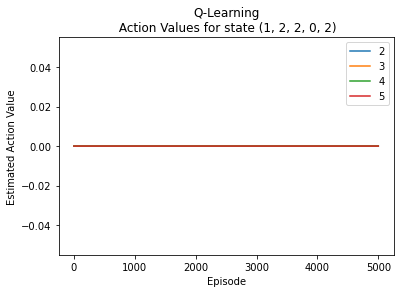

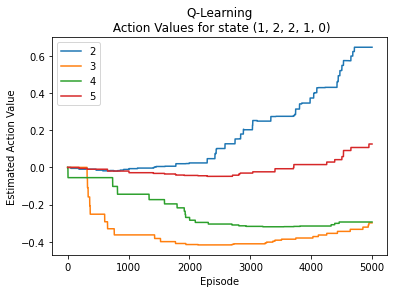

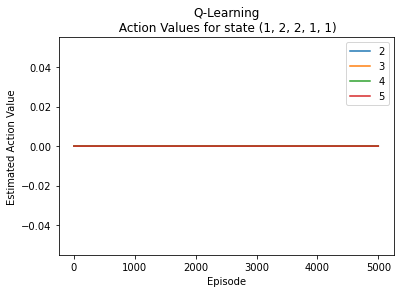

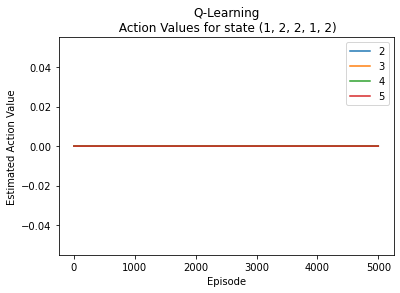

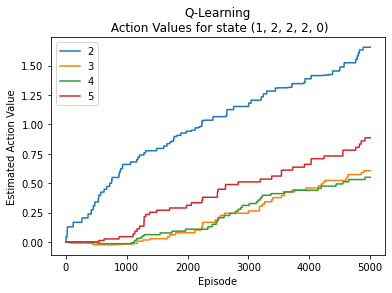

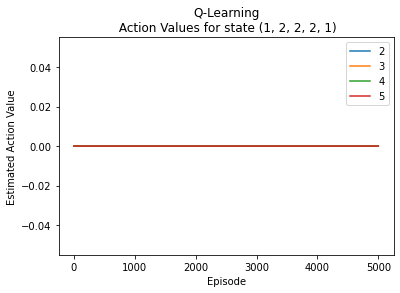

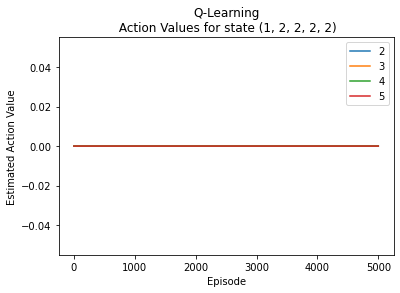

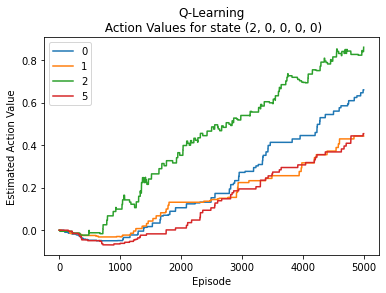

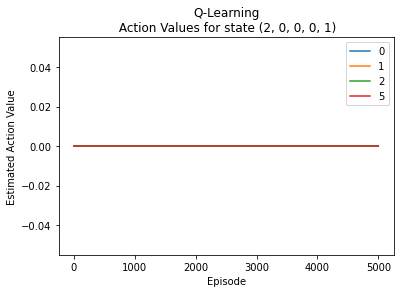

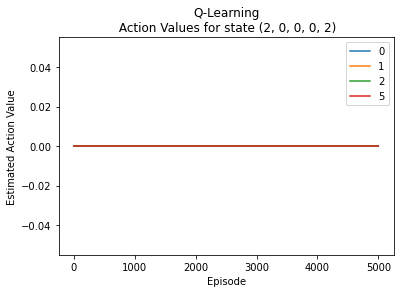

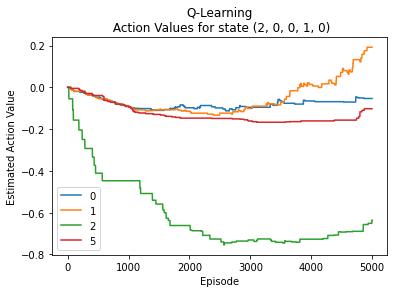

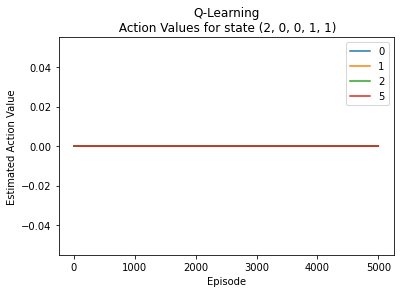

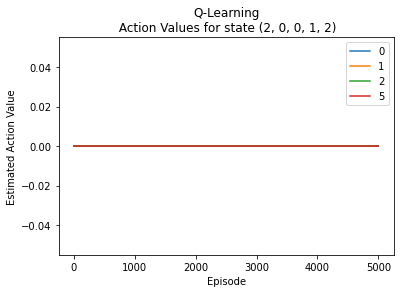

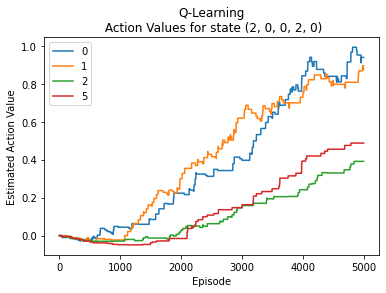

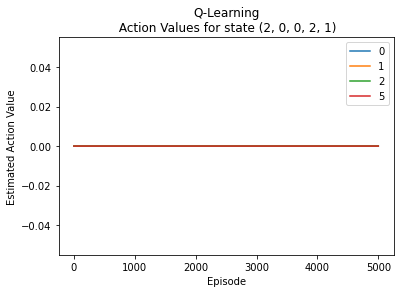

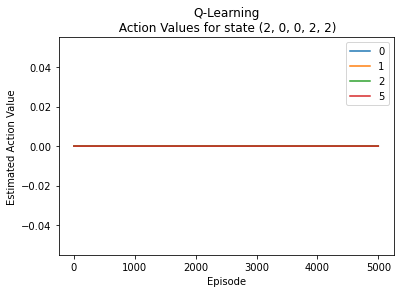

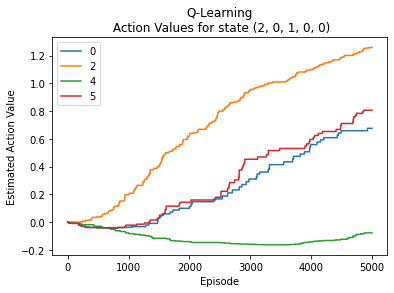

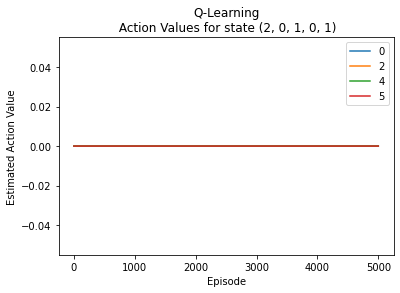

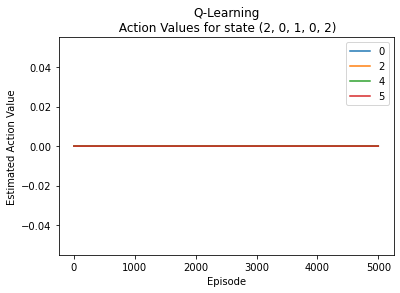

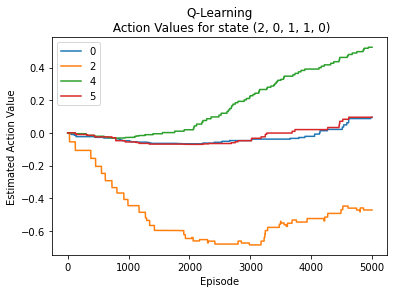

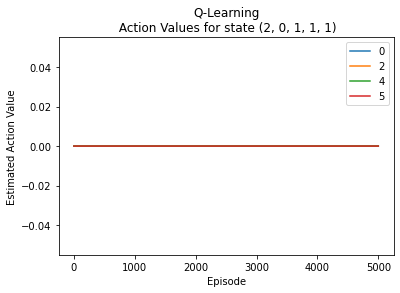

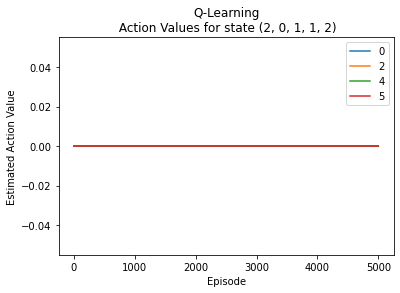

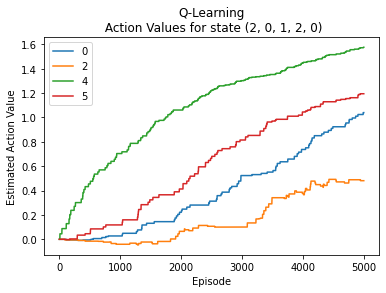

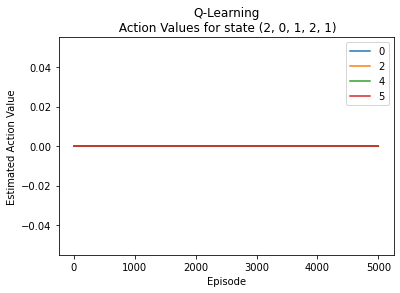

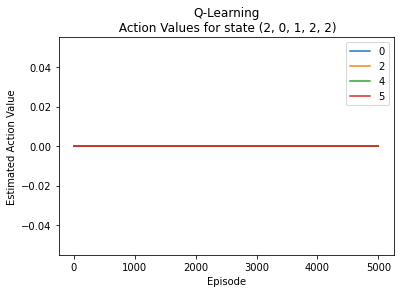

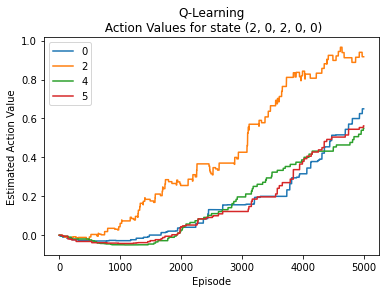

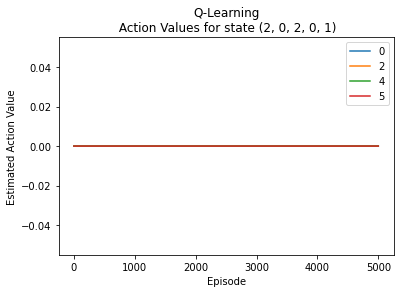

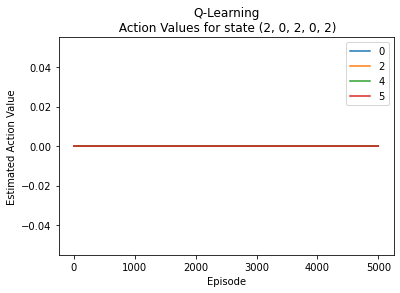

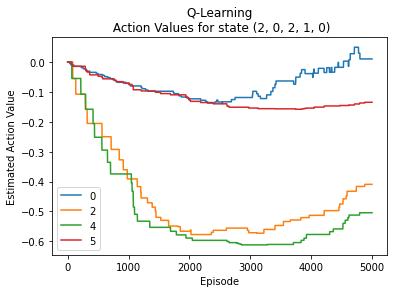

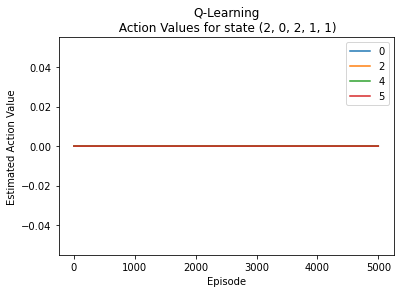

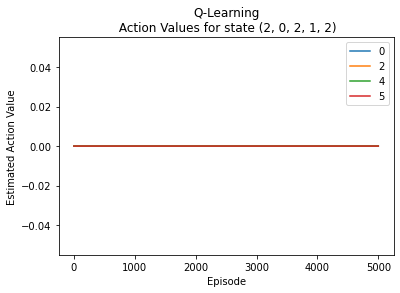

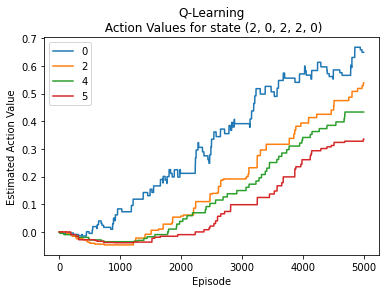

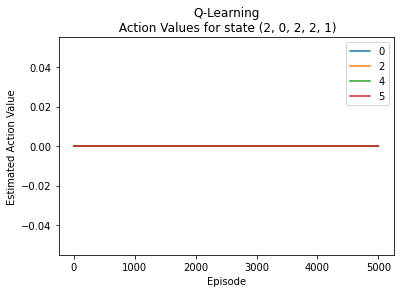

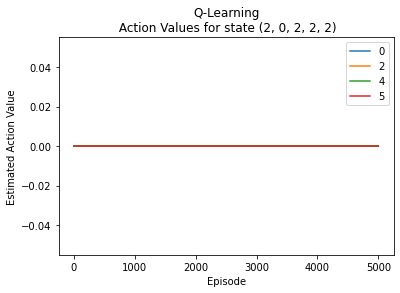

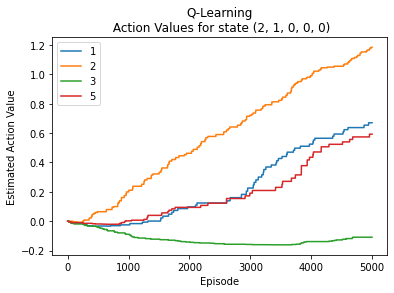

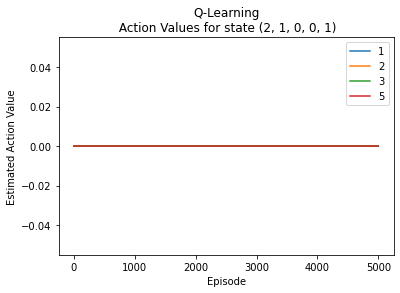

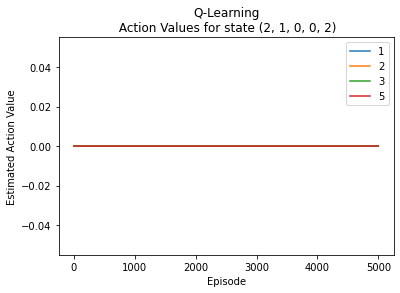

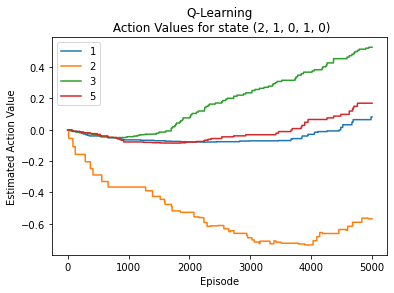

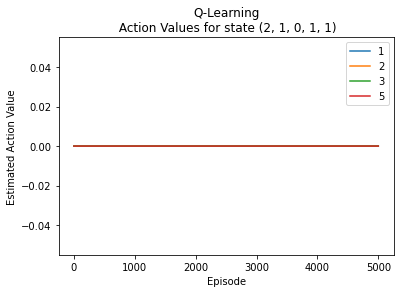

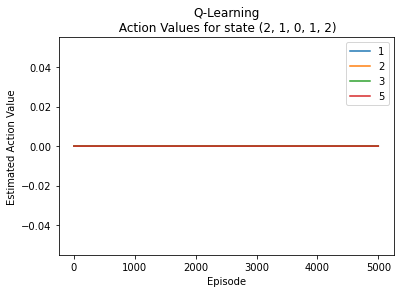

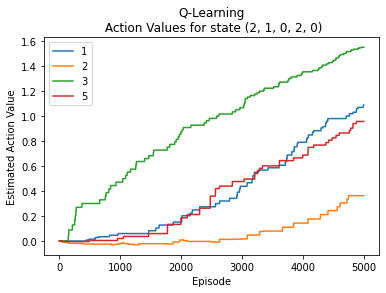

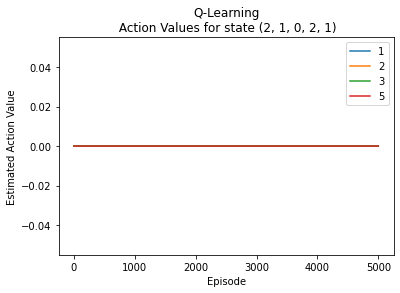

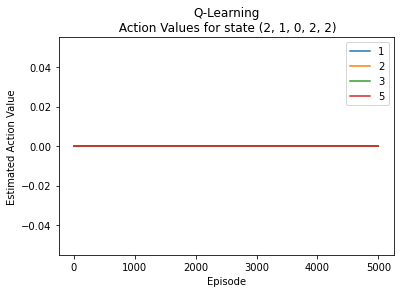

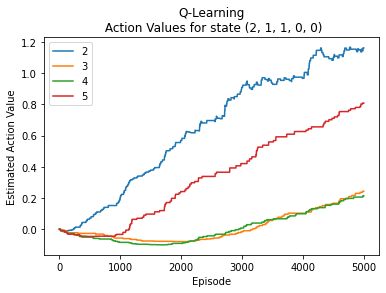

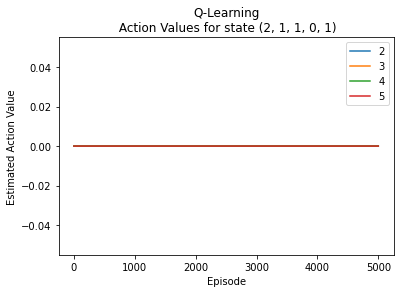

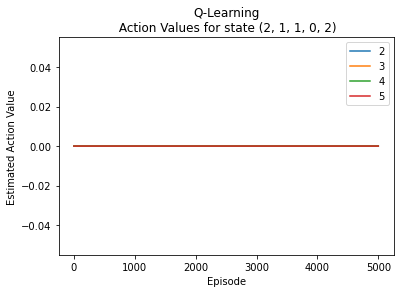

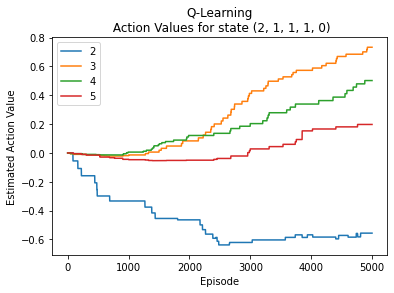

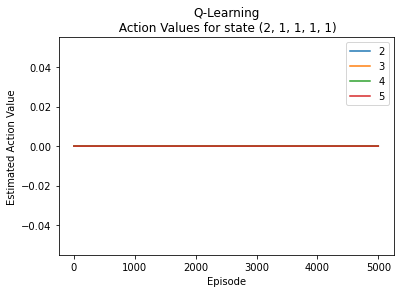

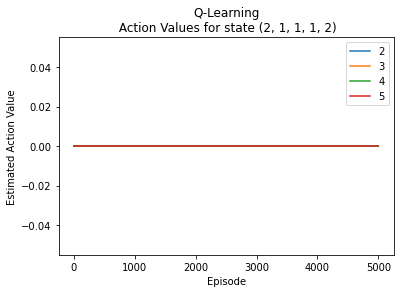

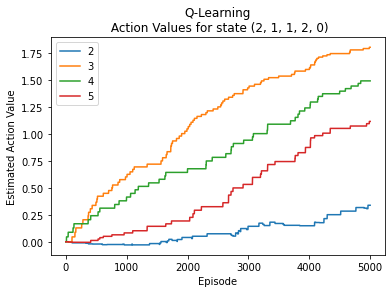

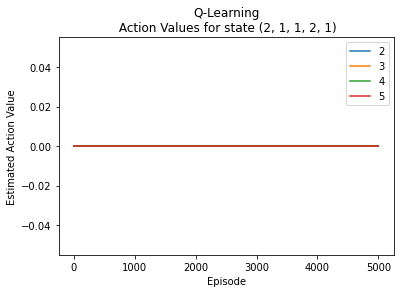

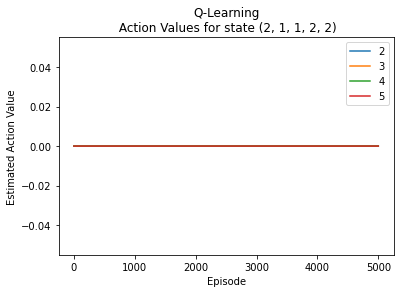

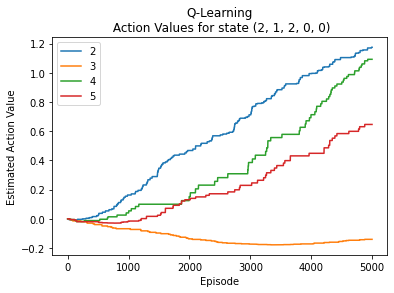

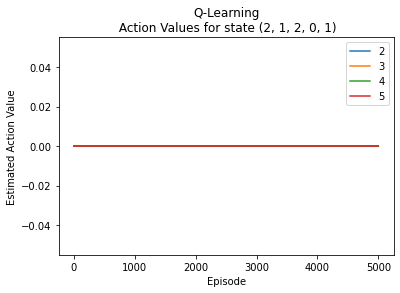

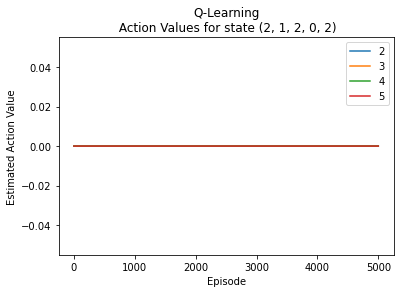

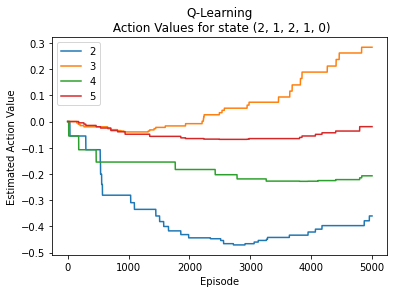

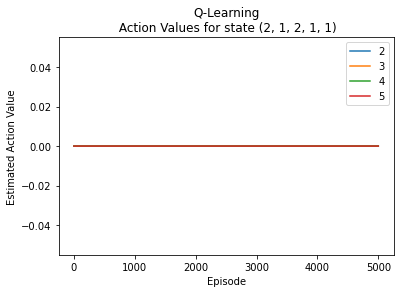

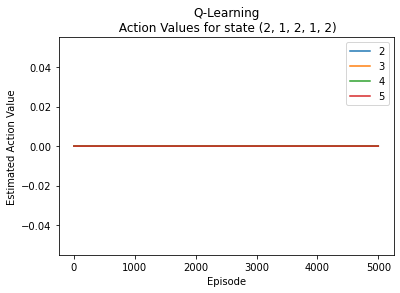

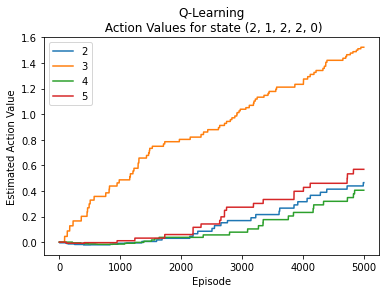

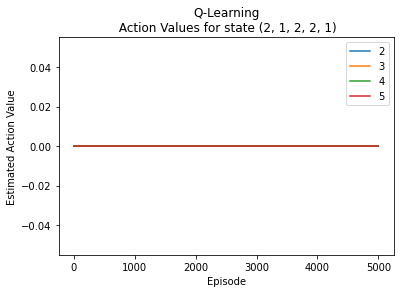

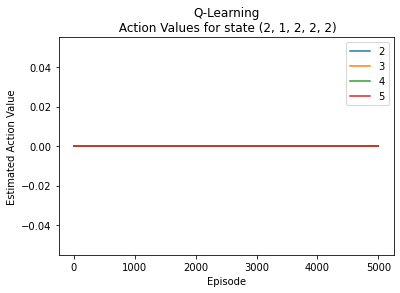

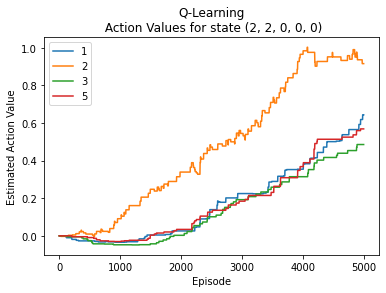

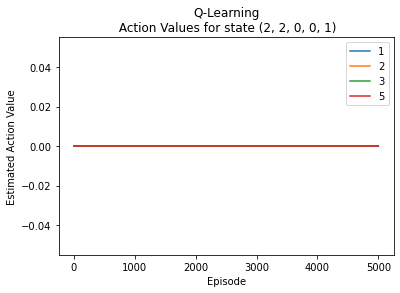

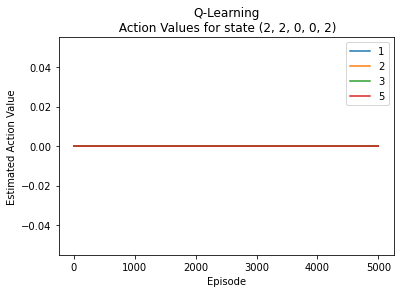

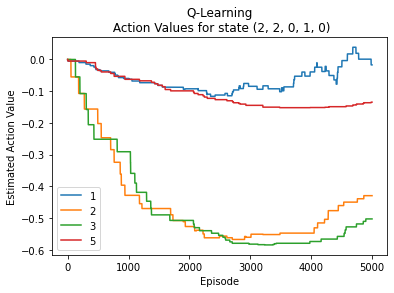

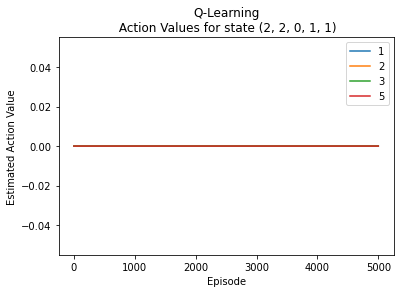

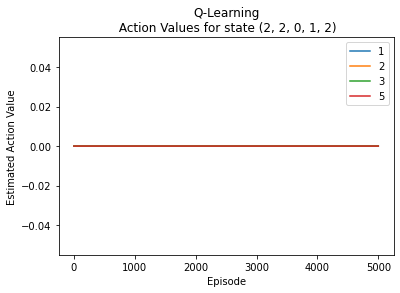

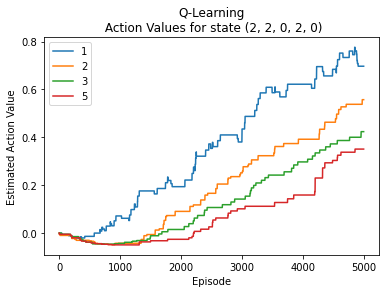

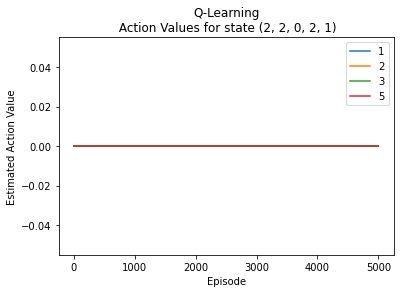

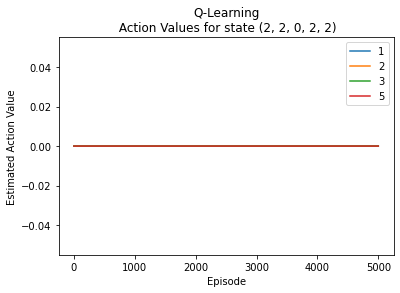

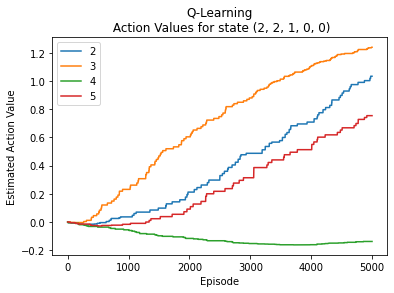

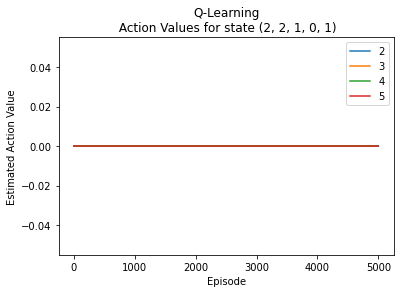

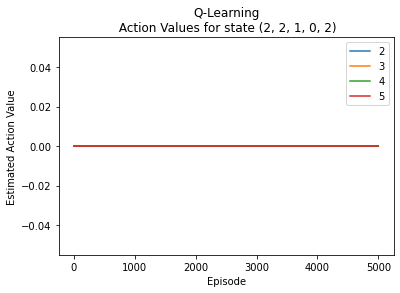

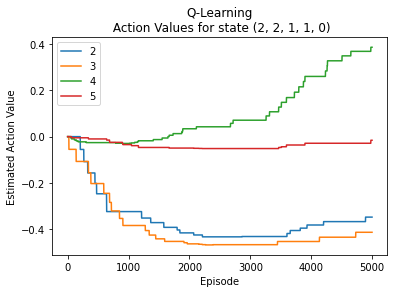

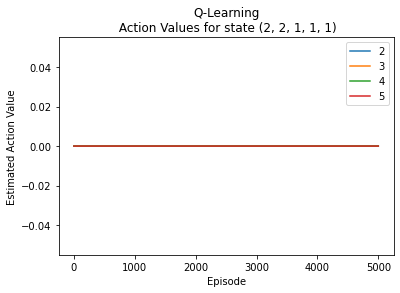

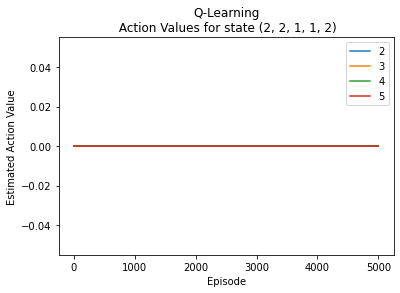

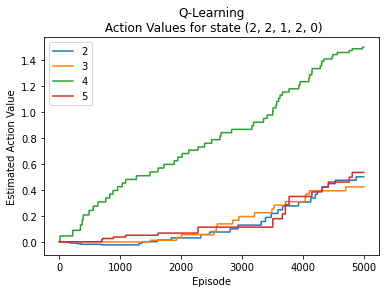

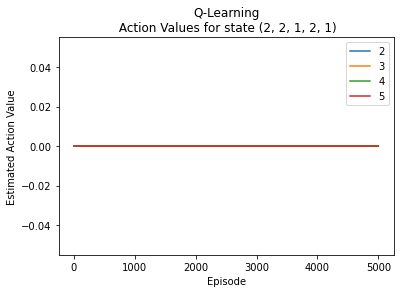

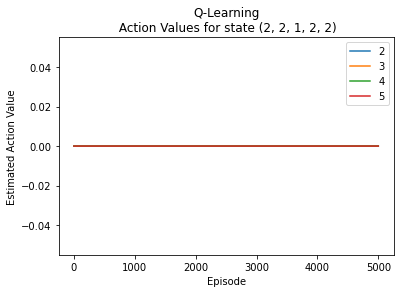

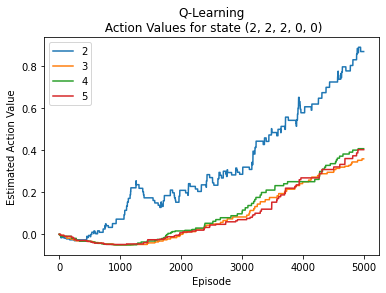

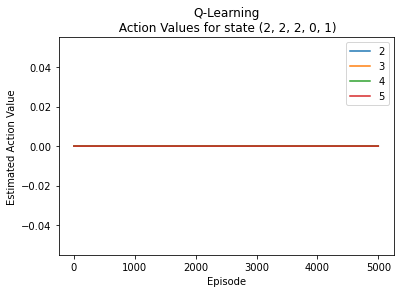

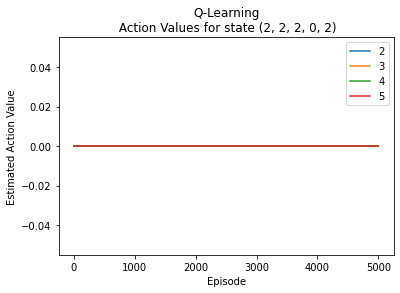

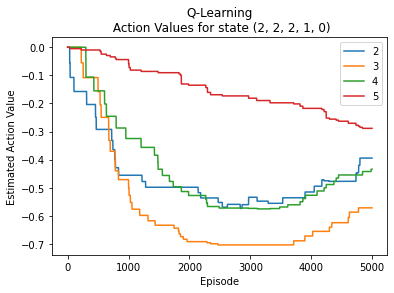

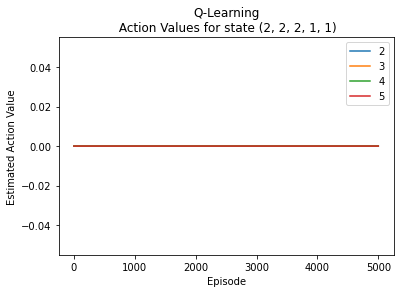

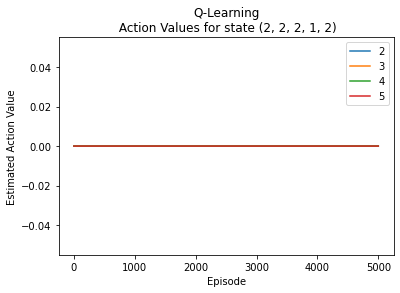

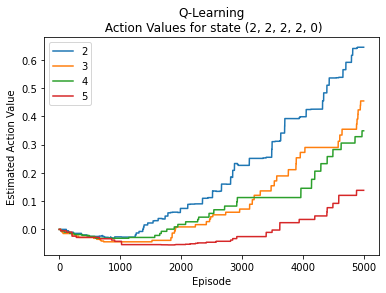

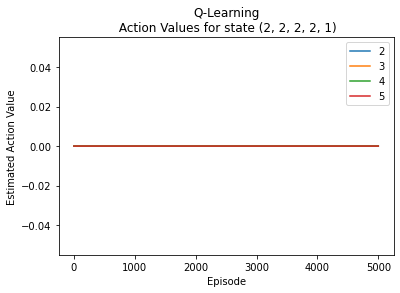

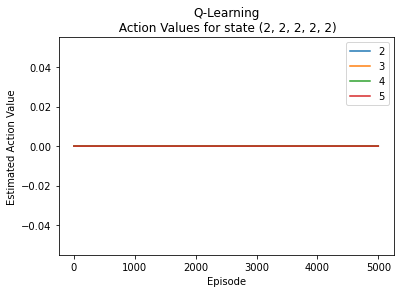

In [8]:
for i, s in enumerate(states):
    plt.figure(i)
    for a, values in Q_plot[s].items():
        plt.plot(values)
    plt.title('Q-Learning\n Action Values for state %s' % str(s))
    plt.ylabel('Estimated Action Value')
    plt.xlabel('Episode')
    plt.legend(Q_plot[s].keys())